In [1]:
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
import pandas as pd

import numpy as np
import os
import shutil
import posixpath
import wfdb
import seaborn as sn

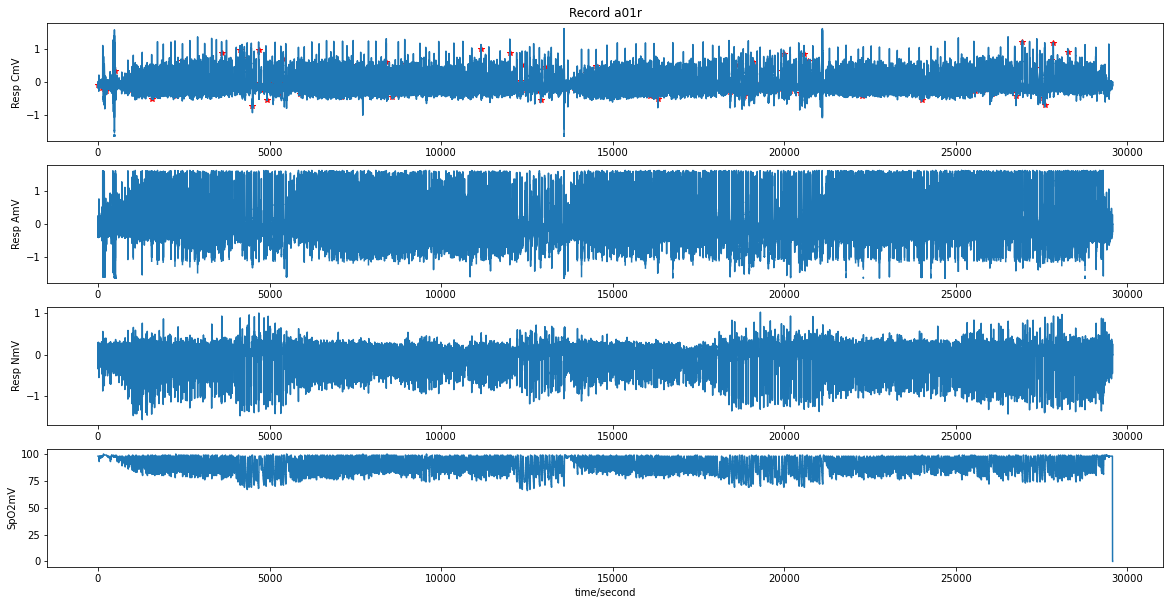

{'record_name': 'a01r',
 'n_sig': 4,
 'fs': 100,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 2956796,
 'base_time': None,
 'base_date': None,
 'comments': [],
 'sig_name': ['Resp C', 'Resp A', 'Resp N', 'SpO2'],
 'p_signal': array([[-0.1015 , -0.3446 ,  0.23545, 98.     ],
        [-0.1025 , -0.3455 ,  0.2364 , 98.     ],
        [-0.1035 , -0.3464 ,  0.23735, 98.     ],
        ...,
        [ 0.     ,  0.     ,  0.     ,  0.     ],
        [ 0.     ,  0.     ,  0.     ,  0.     ],
        [ 0.     ,  0.     ,  0.     ,  0.     ]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['a01r.dat', 'a01r.dat', 'a01r.dat', 'a01r.dat'],
 'fmt': ['16', '16', '16', '16'],
 'samps_per_frame': [1, 1, 1, 1],
 'skew': [None, None, None, None],
 'byte_offset': [None, None, None, None],
 'adc_gain': [20000.0, 20000.0, 20000.0, 1.0],
 'baseline': [0, 0, 0, 0],
 'units': ['mV', 'mV', 'mV', 'mV'],
 'adc_res': [16, 16, 16, 16],
 'adc_zero': [0, 0, 0, 0],
 'init_val

In [10]:
# docs: https://wfdb.readthedocs.io/en/latest/wfdb.html
# SpO2が含まれているデータは a01r のようにrが付いている
# records

subjects = ['a01r', 'a02r', 'a03r', 'a04r', 'b01r', 'c01r', 'c02r', 'c03r']
records = {}

# データの読み込み
for subject in subjects:
    path = "dataset/" + subject
    records[subject] = wfdb.rdrecord(path)  # 計測データ
    records['ann_' + subject] = wfdb.rdann(path, 'apn', shift_samps=True) # ラベル

#record = wfdb.rdrecord('a01r')
#annotation = wfdb.rdann('a01r', 'apn', shift_samps=True)

wfdb.plot_wfdb(record=records['a01r'], annotation=records['ann_a01r'], title='Record a01r', time_units='seconds', figsize=(20,10)) 
display(records['a01r'].__dict__)

In [3]:
# 特徴量の抽出、学習用のデータ作成
# 1 sample(6000個のデータ)毎に基本統計量を出してそれをInputに与える
# 平均、標準偏差、最大値、最小値
# 例) record.p_signal[0:6000], record.p_signal[6001:12001]で統計量を出す
# c01r~c03r はNしかない
        
def extract_feature(data):
    return np.hstack([data.mean().values, data.std().values, data.max().values, data.min().values])

# train用
train_subjects = ['a01r', 'a02r', 'a04r', 'b01r', 'c01r', 'c02r', 'c03r']

# test用
test_subjects = ['a03r']

data_array = []
for subject in train_subjects:
    # annotation分だけ繰り返す
    ann_count = len(records['ann_'+subject].sample)
    data = pd.DataFrame(records[subject].p_signal, columns=records[subject].sig_name, dtype='float')
    print(data.head())

    # 基本統計量を出す
    # data.describe()
    # ピークの差 (data.max() - data.min()).values
    # np.hstack([data.mean().values, data.std().values, data.max().values, data.min().values])
    start_idx = 0
    end_idx = 6000
    for n in range(0, ann_count):
        data_array.append(extract_feature(data[start_idx:end_idx]))
        start_idx = end_idx + 1
        end_idx = end_idx + 6000

test_data = []
for subject in test_subjects:
    ann_count = len(records['ann_'+subject].sample)
    data = pd.DataFrame(records[subject].p_signal, columns=records[subject].sig_name, dtype='float')
    print(data.head())
    start_idx = 0
    end_idx = 6000
    for n in range(0, ann_count):
        test_data.append(extract_feature(data[start_idx:end_idx]))
        start_idx = end_idx + 1
        end_idx = end_idx + 6000

   Resp C  Resp A   Resp N  SpO2
0 -0.1015 -0.3446  0.23545  98.0
1 -0.1025 -0.3455  0.23640  98.0
2 -0.1035 -0.3464  0.23735  98.0
3 -0.1045 -0.3473  0.23830  98.0
4 -0.1055 -0.3482  0.23925  98.0
    Resp C   Resp A   Resp N  SpO2
0 -0.08525  0.22005 -0.41895  96.0
1 -0.08435  0.20915 -0.40935  96.0
2 -0.08345  0.19830 -0.39980  96.0
3 -0.08260  0.18740 -0.39030  96.0
4 -0.08170  0.17655 -0.38070  96.0
    Resp C   Resp A   Resp N  SpO2
0 -0.14035 -0.14400  0.10895  93.0
1 -0.14060 -0.14650  0.11435  93.0
2 -0.14090 -0.14900  0.11980  93.0
3 -0.14120 -0.15155  0.12525  93.0
4 -0.14150 -0.15405  0.13070  93.0
    Resp C   Resp A   Resp N  SpO2
0 -0.09515 -0.08015 -0.04765   0.0
1 -0.09480 -0.07995 -0.04770   0.0
2 -0.09445 -0.07975 -0.04775   0.0
3 -0.09410 -0.07960 -0.04780   0.0
4 -0.09375 -0.07940 -0.04785   0.0
    Resp C   Resp A  Resp N  SpO2
0 -0.11350 -0.94470 -0.0344   0.0
1 -0.11345 -0.94520 -0.0344   0.0
2 -0.11340 -0.94575 -0.0344   0.0
3 -0.11340 -0.94630 -0.0344   0.0
4 

In [4]:
# 学習データ作成
print(len(data_array))
train_X = np.array(data_array)

print(train_X[0].size)
print(train_X[1])
type(train_X)

train_X.shape

# テストデータ作成
print(len(test_data))
test_X = np.array(test_data)
test_X.shape

3436
16
[-5.64733956e-02 -4.05511169e-02  2.24443074e-02  9.73498916e+01
  5.26096529e-02  1.58064974e-01  1.38697215e-01  6.78662729e-01
  8.91000000e-02  5.25450000e-01  3.17350000e-01  9.80000000e+01
 -1.90200000e-01 -4.06650000e-01 -2.87250000e-01  9.60000000e+01]
519


(519, 16)

In [14]:
# NとAを1,0に変換する
# N: 1, A: 0

print(records['ann_a03r'].symbol)

from sklearn.preprocessing import LabelEncoder

label_data = []
for subject in train_subjects:
    le = LabelEncoder()
    le = le.fit(records['ann_' + subject].symbol)
    labels = le.transform(records['ann_' + subject].symbol)
    label_data = np.concatenate([label_data, labels], 0)

# テスト用のラベル
test_label = []
for subject in test_subjects:
    le = LabelEncoder()
    le = le.fit(records['ann_' + subject].symbol)
    test_label = le.transform(records['ann_' + subject].symbol)
    
    
display(label_data)
display(len(label_data))

display(test_label)
display(len(test_label))

['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',

array([1., 1., 1., ..., 0., 0., 0.])

3436

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

519

In [16]:
# https://github.com/rasbt/python-machine-learning-book-3rd-edition の chapter03
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(criterion='gini', 
                                    max_depth=3, 
                                    random_state=1)
tree_model.fit(train_X, label_data)

DecisionTreeClassifier(max_depth=3, random_state=1)

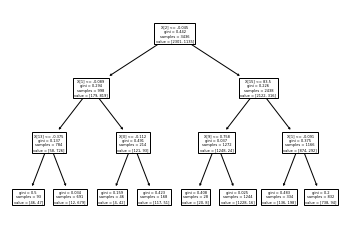

In [17]:
from sklearn import tree

tree.plot_tree(tree_model)
plt.show()

In [20]:
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
import pydotplus
from PIL import Image

#  In addition, eight recordings (a01 through a04, b01, and c01 through c03) are accompanied by four additional signals (Resp C and Resp A, chest and abdominal respiratory effort signals obtained using inductance plethysmography; Resp N, oronasal airflow measured using nasal thermistors; and SpO2, oxygen saturation).

# Resp C: chest respiratory effort signals
# Resp A: abdominal respiratory effort signals
# Resp N: oronasal airflow measured using nasal thermistors
# SpO2: oxygen saturation
dot_data = export_graphviz(tree_model,
                           filled=True, 
                           rounded=True,
                           class_names=['N', 
                                        'A'],
                           feature_names=[
                               'Resp C mean', 'Resp A mean', 'Resp N mean',  'SpO2 mean',
                               'Resp C std', 'Resp A std', 'Resp N std',  'SpO2 std',
                               'Resp C max', 'Resp A max', 'Resp N max',  'SpO2 max',
                               'Resp C min', 'Resp A min', 'Resp N min',  'SpO2 min'
                           ],
                           out_file=None) 
graph = graph_from_dot_data(dot_data) 
graph.write_png('tree.png')

True